In [1]:
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
from scipy.spatial import distance_matrix
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic
#import seaborn as sns
#import dask
#from dask import dataframe as ddf
#from dask.diagnostics import ProgressBar
#from multiprocessing.pool import ThreadPool
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from shapely.geometry import Point
from pyproj import Proj, transform
import geopandas as gpd

In [77]:
data_dtypes = {
    'Card_Number' : 'str',
    #'Origin_Location_ID' : 'int16',
    #'Destination_Location_ID' : 'int16',
    #'Entry': 'str',
    #'Exit': 'str',
    #'Commuter_Category': 'str',
    #'Transport_Mode': 'str',
    #'Trip_ID': 'int16',
    #'Origin_Latitude_Value': 'float32',
    #'Origin_Longitude_Value': 'float32',
    #'Origin_X': 'float32',
    #'Origin_Y': 'float32',
    'Origin_Subzone': 'str',
    #'Destination_Latitude_Value': 'float32',
    #'Destination_Longitude_Value': 'float32',
    #'Destination_X': 'float32',
    #'Destination_Y': 'float32',
    'Destination_Subzone' : 'str',
    'DayOfWeek' : 'int16',
    #'BoardTimeOfDay' : 'int16',
    #'AlightTimeOfDay' : 'int16',
    'duration_seconds': 'float32',
    'distance_meters' : 'int16'
}

In [78]:
data = pd.DataFrame(columns=list(data_dtypes.keys()))

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 6 columns):
Card_Number            0 non-null object
Origin_Subzone         0 non-null object
Destination_Subzone    0 non-null object
DayOfWeek              0 non-null object
duration_seconds       0 non-null object
distance_meters        0 non-null object
dtypes: object(6)
memory usage: 0.0+ bytes


In [79]:
sz = gpd.read_file('urasubzones.json')

In [161]:
grid = {'Origin_Subzone':sz['name'].unique()[:5],
        'Destination_Subzone':sz['name'].unique()[:4],
        'duration_seconds':[60,360,180,270],
        'distance_meters':[5000,6000,7000],
        'DayOfWeek': [4,6]}

In [162]:
result = pd.DataFrame(ParameterGrid(grid),columns=list(data_dtypes.keys()))

In [163]:
import numpy as np
result['Card_Number'] = np.random.randint(1, 60000, result.shape[0])
result['duration_seconds'] = np.random.randint(1, 7200, result.shape[0])

In [164]:
lookup = {'MARINA SOUTH':500, "PEARL'S HILL":1000, 'BOAT QUAY':1500, 'HENDERSON HILL':2000}

In [165]:
result['distance_meters'] = result['Destination_Subzone'].apply(lambda x: int(lookup[x]))

In [166]:
result.loc[result['DayOfWeek'] == 6,'duration_seconds'] = np.random.randint(1000, 3600, len(result.loc[result['DayOfWeek'] == 6]))
result.loc[result['DayOfWeek'] == 6,'distance_meters'] = np.random.randint(4000, 6000, len(result.loc[result['DayOfWeek'] == 6]))

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

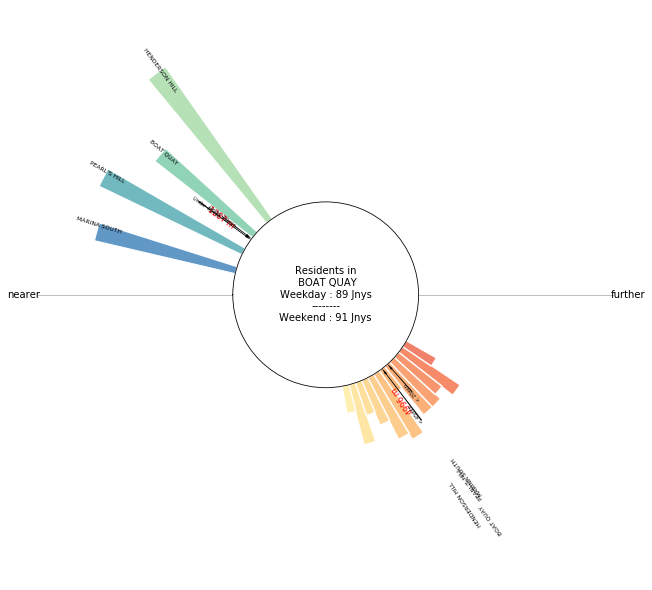

In [167]:
# Make a copy

remove_n = 300
drop_indices = np.random.choice(result.index, remove_n, replace=False)
journeys = result.drop(drop_indices)

subzone = 'BOAT QUAY'

# Parameters for the bars
bins=41
gap = math.radians(5) # gap offset from the horizontal axis
maxdist = 7000 # planareamat.max().max()*0.2

# Image parameters
dpi = 100

# Set the Angles here , split between Weekday and Weekend Journeys
workjnys = journeys.loc[journeys['DayOfWeek'] < 5]
workjnys['Direction'] = -1
playjnys = journeys.loc[journeys['DayOfWeek'] >= 5]
playjnys['Direction'] = 1

# Apply the angles based on distance
anglefn = interp1d([0,maxdist],[0+gap,np.pi-gap],fill_value='extrapolate')
workjnys['theta'] = workjnys['distance_meters'].map(anglefn)*workjnys['Direction']
playjnys['theta'] = playjnys['distance_meters'].map(anglefn)*playjnys['Direction']

alljnys = pd.concat([workjnys,playjnys])
worktotal = len(workjnys)
playtotal = len(playjnys)

# Plot out chart

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1,0.1,0.8,0.8], polar=True)
ax.set_rorigin(-0.5) # Size of Hole in the centre
ax.set_theta_zero_location('W', offset=0) # Rotate 0
ax.set_thetalim([0/180 * np.pi,360/180 * np.pi]) #Cutoff
# ax.axis('off') #Turn off everything
#ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines['polar'].set_visible(False) # Turn off Outer frame

plt.xticks((0,np.pi),('nearer','further'))

## Do the binning here, each Journey is weighted as one

## For Weekday Journeys
x = np.array(workjnys['theta'].values,dtype='float64')
y = np.ones(worktotal)

sums_work, edges_work, _ = binned_statistic(x, y, 'sum', bins=bins, range=(-np.pi+gap,0-gap))
moving_avgs = []
for i,x in enumerate(edges_work):
    if i>=1:
        moving_avgs.append((edges_work[i-1]+edges_work[i])/2)
edges_work = moving_avgs

## For Weekend Journeys
x = np.array(playjnys['theta'].values,dtype='float64')
y = np.ones(playtotal)

sums_play, edges_play, _ = binned_statistic(x, y, 'sum', bins=bins, range=(0+gap,np.pi-gap))
moving_avgs = []

for i,x in enumerate(edges_play):
    if i>=1:
        moving_avgs.append((edges_play[i-1]+edges_play[i])/2)
edges_play = moving_avgs

## Combined them altogether
sums = np.concatenate([sums_play,sums_work])
edges = np.concatenate([edges_play,edges_work])

# Create the bars

bars = ax.bar(edges,
             sums/sums.max(),
             width=np.pi/bins,
             bottom=0.0)   

for bar,e,s in zip(bars,edges,sums):
    bar.set_facecolor(cm.Spectral_r(abs(e/np.pi)))
    bar.set_alpha(0.8)

bars2 = ax.bar(edges,
             sums/sums.max(),
             width=np.pi/bins,
             linewidth=1,
             facecolor='none',
             edgecolor='white',
             alpha=1,
             bottom=0.0) 
    
# Create the annotations
# For weekday
avgworkdist = workjnys['distance_meters'].mean()
avgworktheta = anglefn(avgworkdist)*-1
avgworkunder20 = workjnys.loc[workjnys['duration_seconds'] <= 20*60]['distance_meters'].mean()
avgworkunder45 = workjnys.loc[workjnys['duration_seconds'] <= 45*60]['distance_meters'].mean()
avgworkunder20theta = anglefn(avgworkunder20)*-1
avgworkunder45theta = anglefn(avgworkunder45)*-1

#arrow = mpatches.FancyArrow(avgworktheta , 0.25 , 0, -0.25, width=np.pi/200, length_includes_head=True, facecolor='Red',linewidth=0)
#ax.add_patch(arrow)
ax.annotate('{0:.0f} m'.format(avgworkdist),
            xy=[avgworktheta, 0.2],  # theta, radius
            rotation=avgworktheta*180/np.pi,
            color='Red',
            size=8,
            ha='center',
            va='center',
            )

arrow = mpatches.FancyArrow(avgworkunder20theta , 0.2 , 0, -0.2, width=np.pi/400, length_includes_head=True, facecolor='k', linewidth=0, edgecolor='white')
ax.add_patch(arrow)
ax.annotate('Under 20min'.format(avgworkunder20),
            xy=[avgworkunder20theta, 0.2],  # theta, radius
            rotation=avgworkunder20theta*180/np.pi,
            size=5,
            ha='center',
            va='center',
            )

arrow = mpatches.FancyArrow(avgworkunder45theta , 0.35 , 0, -0.35, width=np.pi/400, length_includes_head=True, facecolor='k', linewidth=0, edgecolor='white')
ax.add_patch(arrow)
ax.annotate('Under 45min'.format(avgworkunder45),
            xy=[avgworkunder45theta, 0.3],  # theta, radius
            rotation=avgworkunder45theta*180/np.pi,
            size=5,
            ha='center',
            va='center',
            )

# For weekend
avgplaydist = playjnys['distance_meters'].mean()
avgplaytheta = anglefn(avgplaydist)*1
avgplayunder20 = playjnys.loc[playjnys['duration_seconds'] <= 20*60]['distance_meters'].mean()
avgplayunder45 = playjnys.loc[playjnys['duration_seconds'] <= 45*60]['distance_meters'].mean()
avgplayunder20theta = anglefn(avgplayunder20)*1
avgplayunder45theta = anglefn(avgplayunder45)*1

#arrow = mpatches.FancyArrow(avgplaytheta , 0.25 , 0, -0.25, width=np.pi/200, length_includes_head=True, facecolor='Red',linewidth=0)
#ax.add_patch(arrow)       
ax.annotate('{0:.0f} m'.format(avgplaydist),
            xy=[avgplaytheta, 0.2],  # theta, radius
            rotation=avgplaytheta*180/np.pi,
            color='Red',
            size=8,
            ha='center',
            va='center',
            )

arrow = mpatches.FancyArrow(avgplayunder20theta , 0.2 , 0, -0.2, width=np.pi/400, length_includes_head=True, facecolor='k', linewidth=0, edgecolor='white')
ax.add_patch(arrow)
ax.annotate('< 20min'.format(avgplayunder20),
            xy=[avgplayunder20theta, 0.2],  # theta, radius
            rotation=avgplayunder20theta*180/np.pi,
            size=5,
            ha='center',
            va='center',
            )

arrow = mpatches.FancyArrow(avgplayunder45theta , 0.35 , 0, -0.35, width=np.pi/400, length_includes_head=True, facecolor='k', linewidth=0, edgecolor='white')
ax.add_patch(arrow)
ax.annotate('< 45min'.format(avgplayunder45),
            xy=[avgplayunder45theta, 0.3],  # theta, radius
            rotation=avgplayunder45theta*180/np.pi,
            size=5,
            ha='center',
            va='center',
            )    

## Annotation
# Weekday Destination Labels
work_labels = workjnys['Destination_Subzone'].value_counts()
work_table = workjnys[['Destination_Subzone','distance_meters']].loc[workjnys['Destination_Subzone'].isin(work_labels.index)].groupby('Destination_Subzone').mean().merge(pd.DataFrame(data=work_labels), left_index=True, right_index=True)
work_table.columns = ['distance', 'r']
work_table['r'] = work_table['r']/work_table['r'].max()
work_table['direction'] = -1
work_table['theta'] = work_table['distance'].map(anglefn)*work_table['direction']

for name,row in work_table.iterrows():
    if (row.r > 0.4):
        text = ax.annotate(name, xy=[row.theta,row.r], rotation=math.degrees(row.theta), ha="center", va="center", size=6) #t*180/np.pi,

# Weekend Destination Labels
play_labels = playjnys['Destination_Subzone'].value_counts()
play_table = playjnys[['Destination_Subzone','distance_meters']].loc[playjnys['Destination_Subzone'].isin(play_labels.index)].groupby('Destination_Subzone').mean().merge(pd.DataFrame(data=play_labels), left_index=True, right_index=True)
play_table.columns = ['distance', 'r']
play_table['r'] = play_table['r']/play_table['r'].max()
play_table['direction'] = 1
play_table['theta'] = play_table['distance'].map(anglefn)*play_table['direction']

for name,row in play_table.iterrows():
    if (row.r > 0.4):
        text = ax.annotate(name, xy=[row.theta,row.r], rotation=math.degrees(row.theta), ha="center", va="center", size=6) #t*180/np.pi,
        

## Centre Chart Text
title = plt.text(x=0.5,
         y=0.55,
         s="Residents in\n {}\nWeekday : {} Jnys\n--------\nWeekend : {} Jnys".format(subzone,worktotal,playtotal),
         horizontalalignment="center",
         verticalalignment="top",
         transform=ax.transAxes,
         bbox={'boxstyle':'circle',
               'facecolor':'white',
               'lw': 0,
               'pad': 2.5})

plt.show()
plt.close()

In [96]:
sz['name'].unique()

array(['MARINA SOUTH', "PEARL'S HILL", 'BOAT QUAY', 'HENDERSON HILL',
       'REDHILL', 'ALEXANDRA HILL', 'BUKIT HO SWEE', 'CLARKE QUAY',
       'PASIR PANJANG 1', 'QUEENSWAY', 'KENT RIDGE', 'ALEXANDRA NORTH',
       'MARINA EAST', 'INSTITUTION HILL', 'ROBERTSON QUAY',
       'JURONG ISLAND AND BUKOM', 'SUDONG', 'SEMAKAU', 'SOUTHERN GROUP',
       'SENTOSA', 'CITY TERMINALS', 'ANSON', 'STRAITS VIEW',
       'MARITIME SQUARE', 'TELOK BLANGAH WAY', 'MAXWELL', 'CECIL',
       'KAMPONG TIONG BAHRU', 'TELOK BLANGAH DRIVE', 'PASIR PANJANG 2',
       'CENTRAL SUBZONE', 'SINGAPORE GENERAL HOSPITAL', 'DEPOT ROAD',
       "PEOPLE'S PARK", 'BUKIT MERAH', 'CHINATOWN', 'PHILLIP',
       'RAFFLES PLACE', 'CHINA SQUARE', 'TIONG BAHRU', 'BAYFRONT SUBZONE',
       'TIONG BAHRU STATION', 'CLIFFORD PIER', 'MARINA EAST (MP)',
       'MARINA CENTRE', 'BRAS BASAH', 'OXLEY', 'CITY HALL', 'MEI CHIN',
       'EAST COAST', "NATIONAL UNIVERSITY OF S'PORE", 'ONE TREE HILL',
       'SOMERSET', 'BENCOOLEN', 'LEONIE

In [2]:
import chart_studio.plotly as py
import numpy as np

data = [dict(
        visible = False,
        line=dict(color='#00CED1', width=6),
        name = '𝜈 = '+str(step),
        x = np.arange(0,10,0.01),
        y = np.sin(step*np.arange(0,10,0.01))) for step in np.arange(0,5,0.1)]
data[10]['visible'] = True

steps = []
for i in range(len(data)):
    step = dict(
        method = 'restyle',
        args = ['visible', [False] * len(data)],
    )
    step['args'][1][i] = True # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active = 10,
    currentvalue = {"prefix": "Frequency: "},
    pad = {"t": 50},
    steps = steps
)]

layout = dict(sliders=sliders)
fig = dict(data=data, layout=layout)

py.iplot(fig, filename='Sine Wave Slider')

ImportError: No module named 'chart_studio'